In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [17]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [18]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
# BATCH_SIZE = 32
# BUFFER_SIZE = 100
# def create_mnist_dataset(data, labels, batch_size):
#     def gen():
#         for img, label in zip(data, labels):
#             img = tf.image.resize_with_pad(img, 16, 16)
#             img = tf.image.grayscale_to_rgb(img)
#             yield img, label
#     ds = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32), ((16, 16, 3),()))
#     return ds.repeat().batch(batch_size)
#train_images = create_mnist_dataset(train_images, train_labels, BATCH_SIZE)

In [19]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [20]:
validation_dir = os.path.join(PATH, 'validation')
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
def rescale_imgs(imgs, labels):
    imgs = (imgs - 127.5) / 127.5
    #imgs = data_augmentation(imgs)
    return imgs, labels

In [22]:
class_names = train_dataset.class_names

train_dataset = train_dataset.map(rescale_imgs)
validation_dataset = validation_dataset.map(rescale_imgs)

In [23]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     #images[i]
#     images[i] = tf.image.convert_image_dtype(images[i], dtype=tf.float32)
#     plt.imshow(images[i] * 0.5 + 0.5)
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [24]:
for img, label in train_dataset.take(1):
    one_img = img[0]
    tf.print(tf.reduce_min(one_img), tf.reduce_max(one_img))
    print(img.shape, label.shape)

-0.994445443 1
(32, 160, 160, 3) (32,)


In [25]:
def create_model(base_model):
    inp = tf.keras.layers.Input(shape=(160, 160, 3))
    x = base_model(inp, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, dtype=tf.float32)(x)
    return tf.keras.Model(inputs=inp, outputs=x)

In [26]:
#ValueError: Input size must be at least 75x75; got `input_shape=(16, 16, 3)`
model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(160,160,3))
model.trainable = False
model = create_model(model)

In [27]:
model.input_shape, model.output_shape

((None, 160, 160, 3), (None, 1))

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 5s 49ms/step - loss: 1.2835 - accuracy: 0.5199

In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 81ms/step - loss: 0.6106 - accuracy: 0.7270 - val_loss: 0.3327 - val_accuracy: 0.8440

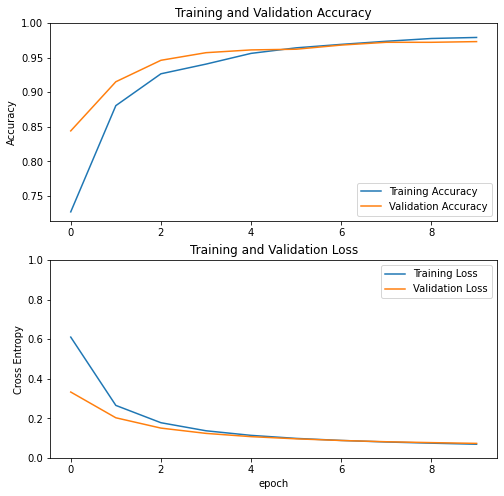

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
